# Hole Filling Using Patch-Matching Algorithm

### The formulation of the problem.

Let we have an image $I\in\mathbb{R}^{H\times W\times 3}$ and a binary mask $M\in \{0,1\}^{H\times W}$. Suppose the pixels of $I$ which are marked by $1$ in the binary mask $M$ are unknown, i.e. we do not know the values $I_{ij}$ for every $i,j$ shuch that $M_{ij} = 1$ (and also we know all the values $I_{ij}$ for every $i,j$ such that $M_{ij}=0$).

The problem is $\textbf{to estimate the unknown values of}$ $I$.

###  The algorithm description.
- dilate the binary mask $M$ in order to get the area, from which we need to pick the pixels to fill the hole. The obtained binary mask let's denote by $M_{dil}$
- obtain such binary mask $M_{get}$ that $M_{get}(i,j) = 0 \Longleftrightarrow M(i,j)=0 \; \mbox{and} \; M_{dil}(i,j) = 1$
- for each scale (s = S, S-1, S-2, ..., 1)
    - downscale the image $I$, the mask $M$ and the mask $M_{get}$ to the size $\frac{H}{2^s}\times\frac{W}{2^s}$; let's denote the corresponding downscaled images by $I^s, M^s, M^s_{get}$
    - if s equals to S
        - fill the hole in $I^s$ (described by the mask $M^s$) with the random values $I^s(i,j)$, where $i,j$ are such coordinates that $M^s_{get}(i,j) = 1$. Upscale the obtained image by the factor $2$ and denote the new image by $I'^{s-1}$.
    - else obtain a new $I^s$ as $I^s = M^s \cdot I'^s + (1 - M^s)\cdot I^s$ and for each index $(i,j)$ for which $M^s(i,j)=1$
        - consider the patch $\omega(i,j)$ of $I^s$, centered at $(i,j)$
        - for some iterations, say $20$
            - find the best matching patch $\omega_{best}$ among all patches centered in such indices $(u,v)$ that $M_{get}(u,v) = 1$ (patch-matching is done with the $l_2$ distance between patches)
            - replace the value $I^s(i,j)$ with the center of the patch $\omega_{best}$
        - upscale the obtained image $I^s$ by the factor $2$ and denote the new image by $I'^{s-1}$.
- return the image $I^1$

#### Let's read the image

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
plt.figure(figsize = (4,4));
# %matplotlib notebook

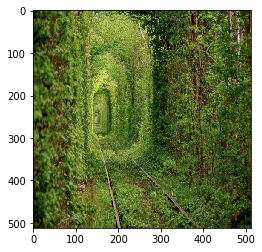

In [2]:
img = cv2.imread('hole_filling.jpg')[:,:,::-1]
img = cv2.resize(img, (512, 512))/ 255.
plt.imshow(img);

#### Let' make a mask to fill

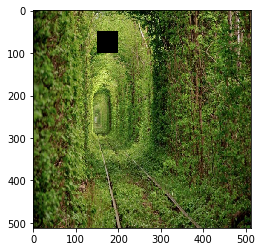

In [3]:
mask_to_fill = np.zeros_like(img[:,:,0])
mask_to_fill[50:100,150:200] = 1.0

# visualize the image with hole
img_with_hole = img.copy()
img_with_hole[np.stack([mask_to_fill]*3, axis = -1) == 1] = 0
plt.imshow(img_with_hole);

### Now let's proceed with the algorithm described above.

#### Get dilated mask and the mask $M_{get}$

In [4]:
# TODO get dilation of the mask with the window sized (21,21)
dilated_mask = cv2.dilate(mask_to_fill, np.ones((21, 21)))
# dilated_mask = cv2.dilate(mask_to_fill, np.ones((41, 41)))

# TODO get the mask M_{get}
mask_to_get_patches = dilated_mask - mask_to_fill

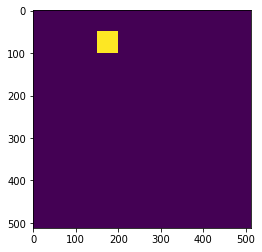

In [5]:
plt.imshow(mask_to_fill)

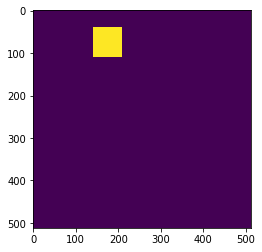

In [6]:
plt.imshow(dilated_mask)

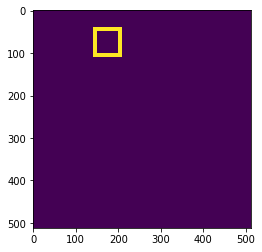

In [7]:
plt.imshow(mask_to_get_patches)

#### The main loop

At first let's define the size of the window for patch matching and pad the image with zeros.

In [8]:
kernel_radius = 10
kernel_size = 2*kernel_radius + 1

img_pad = np.zeros((img.shape[0]+kernel_size-1, img.shape[1]+kernel_size-1, 3))
img_pad[kernel_radius:-kernel_radius, kernel_radius:-kernel_radius,:] = img.copy()

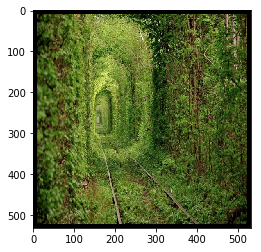

In [9]:
plt.imshow(img_pad)

In [10]:
def ssd(arr1, arr2):
    return np.sum((arr1 - arr2)**2)

In [11]:
def get_where_indices(arr):
    arr = np.where(arr)
    return np.array([[arr[0][i], arr[1][i]] for i in range(len(arr[0]))])

In [12]:
# I = img_pad.copy()
I = img_with_hole.copy()
H, W = img.shape[0], img.shape[1]
I = cv2.resize(I, (W//(2**4), H//(2**4)))
kernel_size = 4
for s in range(4,0,-1):
    I_res = cv2.resize(img, (W//(2**s), H//(2**s)))
    M = cv2.resize(mask_to_fill, (W//(2**s), H//(2**s)), interpolation=cv2.INTER_NEAREST)
    M = np.stack([M]*3, axis = -1)
    M_get = cv2.resize(mask_to_get_patches, (W//(2**s), H//(2**s)), interpolation=cv2.INTER_NEAREST)
    M_get = np.stack([M_get]*3, axis = -1)
    if s == 4:
        # TODO fill the hole M randomly from the M_get and upscale I at the end
        indices = np.column_stack(np.where(M_get == 1))
        for pixel in np.column_stack(np.where(M == 1)):
            pixel_choice = random.choice(indices)
            I_res[pixel[0], pixel[1], pixel[2]] = I_res[pixel_choice[0], pixel_choice[1], pixel_choice[2]]
        I = cv2.resize(I_res, (I_res.shape[0] * (2), I_res.shape[1] * (2)))
    else:
        # TODO define below the main function "fill_the_hole"
        I_res = M * I + (1-M)*I_res
        for pixel in np.column_stack(np.where(M[:, :, 0]==1)):
            i, j = pixel[0], pixel[1]
            patch_i = int(i - kernel_size / 2)
            patch_j = int(j - kernel_size / 2)
            patch_to_replace = I_res[patch_i : patch_i + kernel_size, patch_j : patch_j + kernel_size]
            where_to_get = get_where_indices(M_get[:,:,0])
            
            for _ in range(20):
                np.random.shuffle(where_to_get)
                scores = []
                for idx_get in range(20):
                    i_get, j_get = where_to_get[idx_get]
                    patch_i_get = int(i_get - kernel_size / 2)
                    patch_j_get = int(j_get - kernel_size / 2)
                    patch_to_get = I_res[patch_i_get : patch_i_get + kernel_size, patch_j_get : patch_j_get + kernel_size]
                    
                    score = ssd(patch_to_get, patch_to_replace)
                    scores.append(score) 
                scores = np.array(scores)
                scores_ = np.argwhere(scores == min(scores)).flatten()
                i_best, j_best = where_to_get[random.choice(scores_)]
                I_res[i, j] = I_res[i_best, j_best]
                
        I = cv2.resize(I_res, (I_res.shape[0] * (2), I_res.shape[1] * (2)))

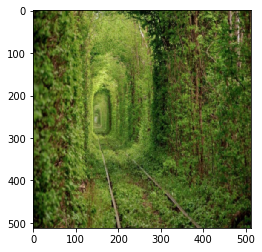

In [13]:
plt.imshow(I)

Now let's define the main function ```fill_the_hole```

In [15]:
# def fill_the_hole():
#     pass